# Deciphering microbial gene function using natural language processing

In this notebook, I rework part of the computation performed in the following paper: https://www.nature.com/articles/s41467-022-33397-4



##  Introduction
In the modern age, where vast amounts of genetic data are accumulating at an unprecedented pace, the exploration of microbial 
communities through metagenomics emerges as a promising frontier. Within these diverse ecosystems lie genes waiting to be understood, 
holding potential applications  in biotechnology and medicine. Yet, many of these genes remain uncharacterized, posing a significant 
challenge to microbial genomics.Depending the concept of genomic context, and natural language processing techniques, the goal is to 
unveil the 'semantics' of genes. By clustering genes into families and analyzing their genomic neighborhoods.



In [73]:
# import general libraries
import codecs
import glob
import multiprocessing
from tqdm import tqdm
import pandas as pd
import os
import re
import csv
import urllib.request
import io
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# importing bioinformatics libraries
import pyrodigal
from Bio import Entrez, SeqIO
from Bio.KEGG import REST

# importing embedding libraries
from gensim.models.word2vec import LineSentence
from gensim.models import word2vec as w2v, Word2Vec

# importinf classification libraries
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import  classification_report, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Analysis

### Step 1: Genomic data downloading and preprocessing: 


1- I downloaded all the biosamples accession numbers, excluding for Eukaryotics, as well as all the metagenomes, that were publicly available in NCBI WGS directly from the following link: https://www.ncbi.nlm.nih.gov/Traces/wgs/

In [194]:
# investigating dataset downloaded fromn NCBI for bacteria
df = pd.read_csv('./downloaded_data/wgs_selector_Bacteria.csv', nrows=10)
df.head()

,prefix_s,project_s,targeted_locus_name_s,div_s,organism_an,bioproject_s,biosample_ss,keyword_ss,infra_name_ss,other_src_ss,...,contigs_proteins_count_l,contigs_annotated_s,scaffolds_count_l,scaffolds_proteins_count_l,scaffolds_total_length_l,scaffolds_annotated_s,scaffolds_range_ss,chromosome_range_ss,update_date_dt,create_date_dt
0,QQNL01,WGS,NaN,BCT,Bifidobacterium breve,PRJNA482538,SAMN09708624,WGS; UNVERIFIED; UNVERIFIED_CONTAMINANT,strain: CUL73,"host: Homo sapiens,isolation_source: feces",...,1978,Yes,0,0,0,No,NaN,NaN,2024-01-29T00:00:00Z,2024-01-29T00:00:00Z
1,QQNU01,WGS,NaN,BCT,Lactobacillus acidophilus,PRJNA482451,SAMN09705759,WGS; UNVERIFIED; UNVERIFIED_CONTAMINANT,strain: 6308,NaN,...,2265,Yes,0,0,0,No,NaN,NaN,2024-01-29T00:00:00Z,2024-01-29T00:00:00Z
2,QQNJ01,WGS,NaN,BCT,Bifidobacterium animalis,PRJNA482547,SAMN09708695,WGS; UNVERIFIED; UNVERIFIED_CONTAMINANT,strain: CUL20,NaN,...,1629,Yes,0,0,0,No,NaN,NaN,2024-01-29T00:00:00Z,2024-01-29T00:00:00Z
3,QQNK01,WGS,NaN,BCT,Bifidobacterium longum,PRJNA482540,SAMN09708657,WGS; UNVERIFIED; UNVERIFIED_CONTAMINANT,strain: CUL75,"host: Homo sapiens,isolation_source: feces",...,1953,Yes,0,0,0,No,NaN,NaN,2024-01-29T00:00:00Z,2024-01-29T00:00:00Z
4,QQNM01,WGS,NaN,BCT,Bifidobacterium breve,PRJNA482528,SAMN09708580,WGS; UNVERIFIED; UNVERIFIED_CONTAMINANT,strain: M16-V,"host: Homo sapiens,isolation_source: feces",...,2027,Yes,0,0,0,No,NaN,NaN,2024-01-29T00:00:00Z,2024-01-29T00:00:00Z


2- I then retrieved FASTA files of genomes and saved them using Entrez package from Biopython library to find ftp links, and urrlib library to scrape the data


In [ ]:
# downloading genomes using biosample accession number

def download_file(url, directory, organism_file):
    '''
    a function to download genomes fasta files using ftp links
    Input:
        url: link for scraping
        directory: parent directory to save information in
        organism_file: the subdirectory for each organism where fasta file should be saved
    Output: 
        Genome files for each organism are downloaded and save in their corresponding folder
    '''
    # creating target subdirectory
    organism_file = '_'.join(organism_file.split( ))  # replace spaces in organism_file with underscores
    directory = directory+'/'+ organism_file  # create full path for the organism
    os.makedirs(directory, exist_ok=True)  # create the directory if it doesn't exist
    filename = url.split('/')[-1]  # extract the filename from the URL

    # scraping the information
    filepath = os.path.join(directory, filename)  # create the full file path
    url = url+ '/'+filename+'_genomic.fna.gz'  # modify the URL to point to the genomic file
    urllib.request.urlretrieve(url, filepath)  # download the file and save it to the filepath

def download_genomes(sample_numbers, download_directory, organisms):
    ''''
    a function to download genomes given biosample accession number

    Input:
        sample numbers: biosample numbers
        download_drectory: path to download_directory to save the file in
        organisms: names of organisms samples belong to

    Output: 
        genomes downloaded and saved in target directory
    '''
    Entrez.email = "randfatttouh@gmail.com"  # Set your email here

    # looping through sample number and search and read their information using Entrez library
    for i in range(len(sample_numbers)):
        sample_number = sample_numbers[i]  # get the current sample number
        organism = organisms[i]  # get the current organism name
        handle = Entrez.esearch(db="assembly", term=f"{sample_number}[BioSample]")  # search for the assembly
        record = Entrez.read(handle)  # read the search results
        handle.close()  # close the handle

        if record['Count'] == "0":  # check if no results were found
            continue  # skip to the next sample number

        assembly_id = record['IdList'][0]  # get the first assembly ID from the results
        # Download assembly summary
        handle = Entrez.esummary(db="assembly", id=assembly_id)
        summary = Entrez.read(handle)
        handle.close()

        # check if 'DocumentSummarySet' and 'DocumentSummary' keys are present
        if 'DocumentSummarySet' in summary and 'DocumentSummary' in summary['DocumentSummarySet']:
            documents = summary['DocumentSummarySet']['DocumentSummary']
            # loop over documents and download their associated genomes using provided ftp_path
            for document in documents:
                if 'FtpPath_GenBank' in document:
                    ftp_link = document['FtpPath_GenBank']
                    ftp_link = ftp_link.replace("ftp://", "https://")
                    # Call the download_file function to download the genome
                    download_file(ftp_link, download_directory, organism)



3- Following that, I used prodigal to predict genes from contigs longer than 10 kbp

In [ ]:
# predicting genes
def predict_genes(tax):
    '''
    a function to predict genes from contigs longer than 10 kbp using prodigal
    Input:
        taxnomy group to find path in deirectory
    Output: 
        the predicted genes from genome files saved as FASTA in their corresponding folders
    '''
    ## predicting genes from genomes
    orf_finder = pyrodigal.GeneFinder(meta=True)  # initializing gene finder with meta mode
    organisms = glob.glob('./downloaded_genomes/'+tax+'/*')  # getting all the subdirectories

    # adding all the genes of one sample in one file
    for organism in organisms:  # looping over directories
        os.makedirs('predicted_genes/'+tax+'/'+organism.split('/')[-1], exist_ok=True)  # creating file for organism in predicted folder
        wgss = glob.glob(organism+'/*')  # getting all biosample files
        for wgs in wgss:  # looping over the biosample files
            new_fasta = []
            with gzip.open(wgs, "rt") as handle:  # opening the genome file in read text mode
                for record in SeqIO.parse(handle, "fasta"):  # parsing the fasta records
                    if len(record) > 10000:  # checking if the contig length is greater than 10 kbp
                        for i, pred in enumerate(orf_finder.find_genes(bytes(record.seq))):  # predicting genes
                            new_fasta.append('>{0}_{1}\n{2}'.format(record.id, i+1, pred.sequence()))  # formatting the gene sequence
            new_path = 'predicted_genes/'+tax+'/'+organism.split('/')[-1]+'/'+wgs.split('/')[-1]+'.fasta'  # creating path for the new fasta file
            with open(new_path, 'w') as f:  # opening the new fasta file in write mode
                f.write('\n'.join(new_fasta))  # writing the predicted genes to the file

# looping through the different taxonomical groups to perform genome downloading and gene prediction
taxonomies = ['Bacteria', 'metagenomes', 'Viruses', 'Archaea']
for tax in taxonomies:  # looping over taxonomies (folders)
    df = pd.read_csv('downloaded_data/wgs_selector_'+tax+'.csv', nrows=50)  # reading the corresponding file
    sample_numbers = df['biosample_ss']  # extracting biosample accession numbers
    organisms = df['organism_an']  # extracting organism names
    download_directory = "downloaded_genomes/"+tax  # setting the parent download directory
    os.makedirs(download_directory, exist_ok=True)  # creating the downloaded_genomes directory
    os.makedirs('predicted_genes/'+tax, exist_ok=True)  # creating the predicted_genes directory
    # calling download_genomes and predict_genes functions
    download_genomes(sample_numbers, download_directory, organisms)  # downloading genomes
    predict_genes(tax)  # predicting genes


4- In the forth step, I deduplicated genes and annotated them. Since metagenomes and microbial genes are different in length, I used BBMAP dedupe utility to get rid of metagenomical duplictaes. 

In [ ]:
# from bbam file path, deduplication of metagenomical genes

# looping through each subdirectory in the metagenomes directory
for T in ../models_and_data/predicted_genes/metagenomes/*/; do
  # getting the basename of the current subdirectory
  T_basename=$(basename "$T")
  # looping through each fasta file in the current subdirectory
  for D in "$T"*.fasta; do
    # getting the basename of the current fasta file without the .fasta extension
    N=$(basename "$D" .fasta)
    # running the dedupe.sh script on the current fasta file and output to a new file with _deduped suffix
    ./dedupe.sh in="$D" out=../models_and_data/predicted_genes/metagenomes/"$T_basename/$N"_deduped.fasta
  done
done



5- Finally, I did annotation using Prokka. For the other taxonomical groups, I used Prokka for both steps (deduplication and annotation).

In [ ]:
# annotation of files using prokka with deduplication for genes not in metagenomes

# looping through each subdirectory in the current directory
for T in */; do
  T=${T%/}  # removing the trailing slash from the directory name
  if [ "$T" != "metagenomes" ]; then  # checking if the directory is not "metagenomes"
    cd "$T"  # chenging to the directory
    for D in */; do  # looping through each subdirectory
      D=${D%/}  # removing the trailing slash from the directory name
      cd "$D"  # changing to the directory
      for F in *.fasta; do  # looping through each fasta file
        N=$(basename $F .fa)  # getting the basename of the file without the .fa extension
        prokka $N --outdir ../../../annotations/"$T/$D" --kingdom $T  # runnin prokka on the file
      done
      cd ..  # changing back to the parent directory
    done
    cd ..  # changing back to the parent directory
  else
    T=${T%/}  # removing the trailing slash from the directory name
    cd "$T"  # changing to the "metagenomes" directory
    for D in */; do  # looping through each subdirectory
      D=${D%/}  # removing the trailing slash from the directory name
      case "$D" in
        viral_metagenome)
          kingdom="Virus"  # setting kingdom to Virus for viral_metagenome
          ;;
        *)
          kingdom="Bacteria"  # defaulting to Bacteria if not specified
          ;;
      esac
      cd "$D"  # changing to the directory
      for F in *_deduped.fasta; do  # looping through each deduped fasta file
        N=$(basename $F .fa)  # getting the basename of the file without the .fa extension
        prokka $N --outdir ../../../annotations/"$T/$D" --rawproduct --metagenome --kingdom "$kingdom"  # running prokka on the file with metagenome option
      done
      cd ..  # changing back to the parent directory
    done
    cd ..  # changing back to the parent directory
  fi
done


## Step 2: KO orthology clustering


1 - Downmoad all KO from KEGG database using using REST module from Bio kegg (biopython).

In [113]:
# extracting all KO othrology information
ko_orth = REST.kegg_list("orthology").read()  # retirieving KO orthology information from KEGG
ko_orth= pd.read_table(io.StringIO(ko_orth), header=None)  # reading the retrieved information into a DataFrame
print(ko_orth.head())  # printing the first few rows of the DataFrame

        0                                                  1
0  K00001  E1.1.1.1, adh; alcohol dehydrogenase [EC:1.1.1.1]
1  K00002  AKR1A1, adh; alcohol dehydrogenase (NADP+) [EC...
2  K00003         hom; homoserine dehydrogenase [EC:1.1.1.3]
3  K00004  BDH, butB; (R,R)-butanediol dehydrogenase / me...
4  K00005          gldA; glycerol dehydrogenase [EC:1.1.1.6]


In [126]:
# retreiving information for a specific KO entry (in this case, K00003)
response = REST.kegg_get('K00003').read() 
third_level_category = None
for line in response.splitlines():
    if line.startswith("BRITE"):
        category_lines = response.splitlines()
        index = category_lines.index(line)
        # Next lines after BRITE contain hierarchy information
        for i in range(index, index+10):
                if i == index+3:
                    third_level_category = category_lines[i].strip()
                    break


Glycine, serine and threonine metabolism


2- Get the list of proteins associated with each ko number.

In [ ]:
# extract proteins associated with each KO number
def extract_protein_associations(ko_info):
    '''
    a function to extract proteins associated with each KO number
    Input:
        KO number
    Output:
        saves a fasta file with all protein sequences associated with each KO number
    '''
    ko_info= REST.kegg_get(ko_info).read()  # retrieve KO information from KEGG
    proteins = ''
    # loop over genes associated with KO and retrieve the proteins associated with them and their sequence
    genes = ko_info.split('GENES')[1].split('\n')  # extract genes associated with KO
    for gene in genes:
        if gene[0] != ' ':  # check if it's a gene entry
            break
        else:
            if '(' in gene:  # check if there are proteins associated with the gene
                access = gene.strip().split(':')[0].lower()
                for num in gene.split(':')[1].split(' '):  # extract proteins
                    if '(' in num:
                        protein = access+':'+num.split('(')[0]
                        proteins += io.StringIO(REST.kegg_get(protein, 'aaseq').read()).getvalue()
    new_path = 'ko_proteins/'+ko_info+'.fasta'
    with open(new_path, 'w') as f:  # save fasta file
        f.write(proteins)
    # getting third level function
    for line in ko_info.splitlines():
        if line.startswith("BRITE"):
            category_lines = response.splitlines()
            index = category_lines.index(line)
            # Next lines after BRITE contain hierarchy information
            for i in range(index, index+10):
                if i == index+3:
                    return category_lines[i].strip()

## calling extract proteins function for each KO number
os.makedirs('ko_proteins/', exist_ok=True)  # create directory for saving KO proteins
functions = []
for ko_info in list(ko_orth[0])[:30]:  # loop through first 30 KO numbers
    functions.append(extract_protein_associations(ko_info))

# building KO function mapping dataframe and saving it
functions_df = pd.DataFrame({'KO': ko_orth[0], 'function': functions})  # create DataFrame with KO and function information
functions_df.to_csv('./ko_function.csv')  # save DataFrame to CSV file


3- Subcluster each KO cluster into smaller groups usng mmseq2

In [ ]:
#subclustering cluster into smaller groups in ko_proteins folder

# looping through each fasta file in the current directory
for T in *.fasta; do
    T=$(basename "$T" .fasta)  # extracting the basename of the fasta file without the .fasta extension
    mkdir -p ./"$T"  # creating a directory with the basename of the fasta file
    mkdir -p ./"$T"/clusters  # creating a 'clusters' subdirectory inside the created directory
    mmseqs createdb "$T".fasta ./"$T"/"$T"DB  # creating a MMseqs2 database from the fasta file
    mmseqs cluster ./"$T"/"$T"DB ./"$T"/clusters/"$T"_clusteredDB tmp  -s 7.5 -c 0.5  # clustering sequences in the database
    mmseqs createtsv ./"$T"/"$T"DB ./"$T"/"$T"DB ./"$T"/clusters/"$T"_clusteredDB ./"$T"/clusters/"$T"_clusteredDB.tsv  # creating a TSV file from the clustered sequences
    mmseqs result2repseq ./"$T"/"$T"DB ./"$T"/clusters/"$T"_clusteredDB ./"$T"/clusters/"$T"_clusteredDB_seq  # getting representative sequences for each cluster
    mmseqs result2flat ./"$T"/"$T"DB ./"$T"/"$T"DB ./"$T"/clusters/"$T"_clusteredDB_seq ./"$T"/clusters/"$T"_clusteredDB_seq.fasta --use-fasta-header  # converting clustered sequences to fasta format
done


4- Filtering of subclusters with smaller than 5 proteins

In [ ]:
# filtering of subclusters smaller than 5 in size
for ko in list(ko_orth[0])[:30]:  # looping through the first 30 KO numbers
    # getting clusters and finding large ones (>5)
    clusters = pd.read_csv('./ko_proteins/'+ko+'/clusters/'+ko+"_clusteredDB.tsv",sep='\t')  # reading cluster information from TSV file
    clusters.columns= ['cluster', 'protein_id']  # renaling columns for clarity
    cluster_counts = clusters['cluster'].value_counts()  # counting occurrences of each cluster
    large_clusters = cluster_counts[cluster_counts > 5].index.tolist()  # getting indices of clusters larger than 5
    
    # saveing information for each large subcluster in a fasta file
    for c in range(len(large_clusters)):  # Loop through each large cluster
        subcluster = list(clusters[clusters['cluster'] == large_clusters[c]]['protein_id'].str.strip())  # Get protein IDs for the current large cluster
        filtered_sequences = []
        for record in SeqIO.parse('./ko_proteins/'+ko+'.fasta', "fasta"):  # iterating through protein sequences
            if record.id in subcluster:  # checking if the protein ID belongs to the current subcluster
                filtered_sequences.append(record)  # adding the protein sequence to the list of filtered sequences
        output_fasta_file = './ko_proteins/subcluster/'+ko+'_'+str(c).zfill(2)+'.fasta'  # Define output fasta file path
        SeqIO.write(filtered_sequences, output_fasta_file, "fasta")  # Write filtered sequences to a fasta file


4- Aligning subcluster with more than five KEGG proteins using MAFFT.

In [ ]:
# aligning subclusters with more than five KEGG proteins using MAFFT

mkdir -p ./models_and_data/ko_proteins/aligned_subcluster/  # create directory for aligned subclusters
for T in ./models_and_data/ko_proteins/subcluster/*.fasta; do  # loop through each fasta file in subcluster directory
    T=$(basename "$T" .fasta)  # extract the basename of the fasta file without the .fasta extension
    ./mafft-linux64/mafft.bat ./models_and_data/ko_proteins/subcluster/"$T".fasta > ./models_and_data/ko_proteins/aligned_subcluster/"$T".fasta  # align fasta file using MAFFT and save the aligned sequences
done



5- Construction of profile HMM with HMMer suite.

In [ ]:
# construction of profile HMM with HMMer suite

mkdir -p ./models_and_data/ko_proteins/hmm_profiles/  # create directory for HMM profiles
for T in ./models_and_data/ko_proteins/aligned_subcluster/*.fasta; do  # loop through each aligned subcluster fasta file
    T=$(basename "$T" .fasta)  # extract the basename of the fasta file without the .fasta extension
    hmmbuild ./models_and_data/ko_proteins/hmm_profiles/"$T".hmm ./models_and_data/ko_proteins/aligned_subcluster/"$T".fasta  # build HMM profile using aligned sequences
done
cat ./models_and_data/ko_proteins/hmm_profiles/*.hmm > ./models_and_data/ko_proteins/hmm_profiles/ko_hmm_database.hmm  # concatenate all HMM profiles into a single database file


6 - Seraching proetins against HMM profile.

In [ ]:

mkdir -p ./models_and_data/ko_proteins/hmm_match/
KO_HMM_DB_DIR="./models_and_data/ko_proteins/hmm_profiles/"
OUTPUT_DIR="./models_and_data/ko_proteins/hmm_match/"

# creation array of HMM profiles
HMM_PROFILES=("${KO_HMM_DB_DIR}"*.hmm)

#looping over teh folders heirachy to get all the files
for T in ./models_and_data/annotations/*/; do
    T=${T%/}
    for D in "$T"/*/; do
        D=${D%/}
        D2=$(basename "$D")
        for F in "$D"/*.faa; do
            F2=$(basename "$F" .faa)
            
            # creating temporary files for concatenated results
            MATCHES_FILE="${OUTPUT_DIR}${D2}_${F2}_matches.tbl"
            DOMAINS_FILE="${OUTPUT_DIR}${D2}_${F2}_domains.tbl"
            > "$MATCHES_FILE"  # emptying the file if it exists
            > "$DOMAINS_FILE"  # emptying the file if it exists
            
            for KO_HMM_DB in "${HMM_PROFILES[@]}"; do
                hmmsearch --cpu 4 \
                          --tblout temp_matches.tbl \
                          --domtblout temp_domains.tbl \
                          -E 1e-6 "$KO_HMM_DB" "$F"
                
                # appending the results to the consolidated files
                cat temp_matches.tbl >> "$MATCHES_FILE"
                cat temp_domains.tbl >> "$DOMAINS_FILE"
            done
            
            # cleaning up temporary files
            rm temp_matches.tbl temp_domains.tbl
        done
    done
done


## Step3: Corpus generation and word embeddings


1- I assigned proteins significantly matching a KO HMM (E-value threshold of 10−6) an identifier according to the best scoring KO subcluster.

In [ ]:
# assining ko subclusters to protein based on hmmsearch
def parse_hmmsearch_output(file_pattern):
    '''
    a function to assign ko subclusters to protein based on hmmsearch if they pass a threshold of 1e-6 for p value
    Input:
        file_pattern, extension of files
    Output:
        list of assigned proteins, and a list of their representative ko
    '''
    assigned_proteins = []  # list to store assigned proteins
    ko_ids = []  # list to store corresponding KO IDs
    for filename in os.listdir('./ko_proteins/hmm_match/'):  # loop through files in hmm_match directory
        best_match = None  # variable to store best match for each file
        if not filename.endswith(file_pattern):  # check if file ends with specified pattern
            continue
        with open('./ko_proteins/hmm_match/'+filename) as f:  # open file for reading
            for line in f:  # loop through each line in the file
                if line.startswith('#') == False:  # check if line does not start with '#'
                    fields = line.strip().split()  # split line into fields
                    target_name = fields[0]  # get target name
                    query_name = fields[2]  # get query name
                    e_value = float(fields[4])  # get E value
                    score = float(fields[5])  # get score
                    if e_value <= 1e-6:  # check if E value is less than or equal to threshold
                        if best_match is None or score > best_match['score']:  # check if current match is better than previous best match
                            best_match = {  # store information of best match
                                'target_name': target_name,
                                'query_name': query_name,
                                'e_value': e_value,
                                'score': score}
        if best_match != None:  # check if best match exists
            assigned_proteins.append(best_match['target_name'])  # append assigned protein to list
            ko_ids.append(best_match['query_name'])  # append corresponding KO ID to list
    return assigned_proteins, ko_ids  # return tuple of lists

# Call the function to parse hmmsearch output and assign KO subclusters to proteins
assigned_proteins, ko_ids = parse_hmmsearch_output('_matches.tbl')


3- Compiling the fasts file of unassigned proteins sequences.

In [94]:
# compiling the list of unassigned proteins in a fasta file
def extract_hypothetical_proteins(ko_assignments):
    '''
    a function to compila the fasta file of unassigned proteins
    INput:
        the list of assigned proteins
    Output:
        save a fasta file of usassigned proteins and their sequences
    '''
    taxonomies = ['Archaea', 'Bacteria', 'metagenomes']  # list of taxonomies
    unique_sequences = set()  # set to store unique protein sequences
    with open("./hypothetical_list.fasta", "w") as out_f:  # open target file for writing
        for tax in taxonomies:  # loop over taxonomies
            for file in os.listdir('./annotations/'+tax+'/'):  # loop over files in taxonomy directory
                for faa_file in glob.glob('./annotations/'+tax+'/'+file+'/*.faa'):  # loop over faa files in taxonomy directory
                    for record in SeqIO.parse(faa_file, "fasta"):  # iterate over records in faa file
                        if record.id not in ko_assignments:  # check if protein is not assigned to KO
                            if str(record.seq) not in unique_sequences:  # check for sequence uniqueness
                                unique_sequences.add(str(record.seq))  # add sequence to set
                                SeqIO.write(record, out_f, "fasta")  # write record to output file

# Example usage:
extract_hypothetical_proteins(assigned_proteins)  # call the function to compile the list of unassigned proteins

4- clustering them based on amino acid sequence similarity using cd-hit and then subclustering using mmseq2 using the same previous parameters.

In [ ]:

# clustring proteins using CD-HIT with a sequence identity threshold of 80%
cd-hit -i hypothetical_list.fasta -o clustered_proteins.fasta -c 0.80 -s 0.80

# creating a MMseqs2 database from the clustered proteins fasta file
mmseqs createdb clustered_proteins.fasta clustered_proteins_DB

# clustering the proteins using MMseqs2 with a minimum sequence identity of 50% and a coverage threshold of 50%
mmseqs cluster clustered_proteins_DB clustered_proteins_clu tmp --s 0.75 -c 0.5

# generating a TSV file containing the clustering results
mmseqs createtsv clustered_proteins_DB clustered_proteins_DB clustered_proteins_clu_DB clustered_proteins.tsv


In [96]:
# getting a list of unassigned proteins and their hypothetical cluster
def parse_clusters():
    '''
    function to parse resulting cluster and their proteins
    output:
        list of proteins and hypothetical clusters
    '''
    clusters = []  # list to store cluster IDs
    proteins = []  # list to store protein IDs
    cluster_num = 0  # variable to track cluster number
    cluster_gr = ''  # variable to track current cluster group
    reader = pd.read_csv('clustered_proteins.tsv', delimiter='\t', header=None)  # reading clustering results
    reader.columns = ['protein', 'cluster']  # naling columns
    for _, row in reader.iterrows():  # iterating over rows in the clustering results
        protein_id = row['protein']  # getting protein ID
        cluster_id = row['cluster']  # getting cluster ID
        if cluster_id != cluster_gr:  # chacking if new cluster group
            cluster_gr = cluster_id  # updating cluster group
            cluster_num += 1  # increasing cluster number
        clusters.append('hypo.clst.' + str(cluster_num).zfill(4))  # appending cluster ID to list
        proteins.append(protein_id)  # apoending protein ID to list
    return proteins, clusters  # returning lists of proteins and clusters

# calling the function to parse clusters
unassigned_proteins, hypo_ids = parse_clusters()

# merging all proteins and clusters into one dataframe
proteins_clusters = pd.DataFrame({'proteins': assigned_proteins + unassigned_proteins, 'clusters': ko_ids + hypo_ids})



5- Generating corpus files, where each contig is considered a sentence and each protein is replaced by a word.

In [ ]:
os.makedirs('./gen_corpus/', exist_ok=True)
def generate_corpus():
    '''
    function to replace contigs woth representative words
    Output: 
        for each organism, a text file is created with protein in each contig replaced by cluster, seperated by space
        and contigs seperated by . as sentences
    '''
    taxonomies = ['Bacteria', 'metagenomes', 'Viruses', 'Archaea']  # list of taxonomies
    for tax in taxonomies:  # loop through each taxonomy
        for filename in os.listdir('./annotations/'+tax+'/'):  # iterate through files in taxonomy directory
            with open('./gen_corpus/'+filename+'.txt', 'w') as file:  # open file for writing
                for faa_file in glob.glob('./annotations/'+tax+'/'+filename+'/*.faa'):  # iterate through faa files
                    for record in SeqIO.parse(faa_file, "fasta"):  # iterate through records in fasta file
                        # replace proteins with subcluster names
                        word = proteins_clusters.loc[proteins_clusters['proteins'] == record.id, 'clusters'].iloc[0]
                        file.write(" "+ word)  # write word to file
                    file.write('.')  # write '.' to indicate end of contig
                     
# Call the function to generate the corpus
generate_corpus()

## Word embedding

After compiling the dataset and replacing proteins by by their subcluster_id, I did word emmbedding using word2vec.



In [2]:
# loading the files
texts = glob.glob('./corpus/*')  # getting a list of file paths in the 'corpus' directory
texts.sort()  # sorting the list of file paths
print(f"Number of files in corpus: {len(texts)}")  # printing the number of files in the corpus

# adding all the files in one string (corpus)
with open('outputs/tokens.csv', 'w') as file:  # opening a file 'tokens.csv' for writing
    writer = csv.writer(file)  # creating a CSV writer object
    for t in tqdm(texts):  # iterating through each file path in the 'texts' list
        with codecs.open(t, "r", "utf-8") as text:  # opening the file for reading
            paragraph = text.read()  # reading the entire contents of the file as a string
            sentences = paragraph.split(". ")  # splitting the paragraph into sentences based on '.' as delimiter
            for sentence in sentences:  # iterating through each sentence
                if len(sentence) > 0:  # chacking if the sentence is not empty
                    writer.writerow([sentence])  # writing the sentence to the CSV file as a single row


Number of files in corpus: 80965


100%|██████████| 80965/80965 [01:49<00:00, 739.59it/s] 


2- Building the word2vec model.

In [4]:
# load corpus line by line
sentences = LineSentence('outputs/tokens.csv')  # load the corpus line by line from 'tokens.csv'

# building the word2vec model
emb_model = w2v.Word2Vec(  # initiate a Word2Vec model
        sg=1,  # use Skip-gram architecture
        seed=42,  # set the random seed for reproducibility
        workers=multiprocessing.cpu_count(),  # use all available CPU cores
        vector_size=300,  # set the dimensionality of the word vectors to 300
        min_count=24,  # ignore all words with total frequency lower than 24
        window=5,  # set the maximum distance between the current and predicted word within a sentence to 5
        sample=1e-3  # set the threshold for configuring which higher-frequency words are randomly downsampled
    )
emb_model.build_vocab(sentences)  # build the vocabulary from the corpus
print("Gene2Vec vocabulary length:", len(emb_model.wv.index_to_key))  # print the length of the vocabulary

# training the model
emb_model.train(sentences, total_examples=emb_model.corpus_count, epochs=5)  # train the Word2Vec model for 5 epochs

# save model
emb_model.save('outputs/emb_model_24')  # save the trained Word2Vec model to 'emb_model_24'


Gene2Vec vocabulary length: 563841


## Classification



1- splitting the knowen functions from hypothetical clusters to train the model on the first.

In [109]:
# loading word2vec model
emb_model = Word2Vec.load("outputs/emb_model_24")  # loading the trained Word2Vec model from "emb_model_24"

# splitting known and unknown embeddings
idxs = [emb_model.wv.index_to_key.index(word) for word in emb_model.wv.index_to_key if 'hypo' not in word]  # getting indices of known words
known_words = [word for word in emb_model.wv.index_to_key if 'hypo' not in word]  # getting list of known words
known_word2index = {'word': known_words, 'index': idxs}  # creating a dictionary mapping known words to their indices

predict_idxs = [i for i in range(563589) if i not in idxs]  # getting indices of unknown words
predict_embeddings = emb_model.wv.vectors[predict_idxs]  # extracting embeddings of unknown words
predict_word_index = {emb_model.wv.index_to_key[word]: i for i, word in enumerate(predict_idxs)}  # creating a dictionary mapping unknown words to their indices


2- Loading and merging y data

In [32]:
## loading metadata for function and getting function of each word (suncluster)
metadata = pd.read_csv('metadata.csv') 
metadata['label'] = metadata['label'].apply(lambda x: re.split('(.)\[|\(|,', x)[0].strip()) #

3- keeping classes from curated list and adding samples from the rest classes as others

In [33]:
# loading metadata for function and getting function of each word (subcluster)
metadata = pd.read_csv('metadata.csv')  # Load metadata from 'metadata.csv' file
metadata['label'] = metadata['label'].apply(lambda x: re.split('(.)\[|\(|,', x)[0].strip())  # Extract function label from each entry in 'label' column
# if word does not belong to one of the curated labels it is considered as other
curated_labels_no_pumps = ['Amino sugar and nucleotide sugar metabolism',
                  'Benzoate degradation',
                  'Energy metabolism',
                  'Oxidative phosphorylation',
                  'Porphyrin and chlorophyll metabolism',
                  'Prokaryotic defense system',
                  'Ribosome',
                  'Secretion system',
                  'Two-component system']

# keeping only targets from list, rest are Other class
eff_words = pd.DataFrame(known_word2index)  # creating DataFrame from known_word2index dictionary
eff_words["KO"] = eff_words["word"].apply(lambda x: x.rsplit(".")[0])  # extracting KO number from word
eff_words = eff_words.merge(metadata, on=["KO"], how='left')[["word","index",'label']]  # merging with metadata, keeping only relevant columns

chosen_df = eff_words[eff_words['label'].isin(curated_labels_no_pumps)]  # filtering DataFrame to include only chosen labels
# finding categories not in the chosen list
other_categories = eff_words[~eff_words['label'].isin(curated_labels_no_pumps)]['label'].unique()

# initiating an empty list for the "Other" category KOs
other_category_KOs = pd.DataFrame(columns=['word', 'index'])

# sampling 20 KOs from each category not in chosen_categories if it has more than 50 KOs
for category in other_categories:
    category_KOs = eff_words[eff_words['label'] == category]  # filtering DataFrame to include only KOs from current category
    if len(category_KOs) > 150:  # checking if the category has more than 150 KOs
        sampled_KOs = category_KOs.sample(n=100, random_state=42)[['word', 'index']]  # sampling 100 KOs from the category
        other_category_KOs = pd.concat([other_category_KOs, sampled_KOs])  # concatenating sampled KOs with other_category_KOs

# adding the sampled words to the chosen classes
other_df = pd.DataFrame({'word': other_category_KOs['word'],'index': other_category_KOs['index'], 'label': ['Other'] * other_category_KOs.shape[0]})

# combonong with the original DataFrame
combined_df = pd.concat([chosen_df, other_df], ignore_index=True)

# getting the embedding of the words
known_embeddings = emb_model.wv.vectors[list(combined_df['index'])]  # getting embeddings of the words based on their indices


4- splitting data into train and test datasets

In [34]:
# split data into test and train
train_x, test_x, train_y, test_y = train_test_split(known_embeddings, combined_df['label'], test_size=0.2, stratify= combined_df['label'], random_state = 42)

# encoding classes as nulbers
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)

5- testing and tuning parameters:

Models tested and hypertuned are:
* Random forest
* XGBoost
* Three-layered CNN

The best model was CNN with 92% accuracy on test dataset.
The scoring function used for optimizing was F1  sore.

In [51]:
# search space for random forest
random_grid = {'bootstrap': [True, False],
 'max_depth': [5,10, 20, 30, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400,800]}

# search space for xgboost

params = {
        'n_estimators':[200, 400, 800],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,10, 20, 30, 50, None]
        }

In [59]:
# hypertuning and fitting random forest
rf_model = RandomForestClassifier(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, 
                                cv = 3, random_state=42, n_jobs = -1,verbose=0, scoring='f1_weighted')
rf_random.fit(train_x, train_y)
best_fit_rf = rf_random.best_estimator_

# fitting of the best model train data
best_fit_rf.fit(train_x, train_y)

#saving the model
with open('outputs/model_rf_cl_acc.pkl','wb') as f:
    pickle.dump(best_fit_rf,f)

#testing the model
predict_y = best_fit_rf.predict(test_x)
print(classification_report(test_y, predict_y))

#saving scores
accurac_rf = accuracy_score(test_y, predict_y)
f1_rf = f1_score(test_y, predict_y, average='weighted')

                                             precision    recall  f1-score   support

Amino sugar and nucleotide sugar metabolism       1.00      0.02      0.03        62
                       Benzoate degradation       0.00      0.00      0.00        34
                          Energy metabolism       1.00      0.14      0.25        42
                                      Other       0.54      0.98      0.70       860
                  Oxidative phosphorylation       1.00      0.13      0.23        84
       Porphyrin and chlorophyll metabolism       1.00      0.07      0.14        55
                 Prokaryotic defense system       0.96      0.49      0.65       174
                                   Ribosome       0.95      0.18      0.31        98
                           Secretion system       0.90      0.67      0.77       323
                       Two-component system       1.00      0.12      0.21       235

                                   accuracy                    

In [60]:
# training and hypertuning xgboost model
xgb_model = xgb.XGBClassifier(random_state = 42)
xgb_random = RandomizedSearchCV(xgb_model, param_distributions=params,
                                cv = 3, random_state=42, n_jobs = -1,verbose=0, scoring = 'f1_weighted')

# fitting the  best model with train data
xgb_random.fit(train_x, train_y_encoded)
best_fit_xgb = xgb_random.best_estimator_

# fitting with thz whole dataset
best_fit_xgb.fit(train_x, train_y_encoded)

# saving the best model
with open('outputs/model_xgb_cl_acc.pkl','wb') as f:
    pickle.dump(best_fit_xgb,f)
#testing the model with test data
predict_y = best_fit_xgb.predict(test_x)
print(classification_report(test_y, label_encoder.inverse_transform(predict_y)))

#saving scores
accurac_xgb = accuracy_score(test_y, label_encoder.inverse_transform(predict_y))
f1_xgb = f1_score(test_y, label_encoder.inverse_transform(predict_y), average='weighted')


                                             precision    recall  f1-score   support

Amino sugar and nucleotide sugar metabolism       0.69      0.32      0.44        62
                       Benzoate degradation       0.83      0.56      0.67        34
                          Energy metabolism       0.76      0.45      0.57        42
                                      Other       0.67      0.87      0.76       860
                  Oxidative phosphorylation       0.83      0.52      0.64        84
       Porphyrin and chlorophyll metabolism       0.89      0.44      0.59        55
                 Prokaryotic defense system       0.84      0.76      0.80       174
                                   Ribosome       0.75      0.42      0.54        98
                           Secretion system       0.81      0.75      0.78       323
                       Two-component system       0.75      0.55      0.64       235

                                   accuracy                    

In [ ]:
# build the cnn structure
class DNN_network_acc():
    def __init__(self):
        super().__init__()
        self.name = "DNN_network_acc"

    def create_model(self, n):  
        '''
        building the three layers with relu activationa nd ouput layer with softmax
        '''
        # compiling the model
        model = tf.keras.models.Sequential([tf.keras.layers.Input(shape=(300,)),
                                            tf.keras.layers.Dense(256, activation='relu'),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.Dense(128, activation='relu'),
                                            tf.keras.layers.Dropout(0.2),
                                            tf.keras.layers.Dense(64, activation='relu'),
                                            tf.keras.layers.Dense(n, activation='softmax')])
        # setting the scoring function, optimizer and loss
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.F1Score(average='weighted')])
        return model

    def model_fit(self, X_train, y_train_encoded):
        '''
        hypertuning the model
        '''
        #params to be hypertuned
        param_dist = {  # Units per hidden layer
            'batch_size': [64, 128,256],
            'epochs': [10, 20, 30]
        }

        # defining anf fitting the model
        clf = KerasClassifier(model=self.create_model(n=np.unique(y_train_encoded).size), verbose=0)
        dnn_random = GridSearchCV(clf, param_grid=param_dist, cv=3, n_jobs=-1)
        dnn_random.fit(X_train, y_train_encoded)

        # refitting best estimator with the whole dataset
        best_clf = dnn_random.best_estimator_
        best_clf.fit(X_train, y_train_encoded)

        return best_clf
#finding the best cnn model after hypertunign
dnn_network = DNN_network_acc()

#fitting with the whole dataset
best_fit_cnn = dnn_network.model_fit(train_x, train_y_encoded)

In [63]:
#saving the model
with open('outputs/model_cnn_cl_acc.pkl','wb') as f:
    pickle.dump(best_fit_cnn,f)


#testing the model with test dataset
predict_y = best_fit_cnn.predict(test_x)

print(classification_report(test_y, label_encoder.inverse_transform(predict_y)))

#saving  accuracy and f1 scores
accurac_cnn = accuracy_score(test_y, label_encoder.inverse_transform(predict_y))
f1_cnn = f1_score(test_y, label_encoder.inverse_transform(predict_y), average='weighted')

                                             precision    recall  f1-score   support

Amino sugar and nucleotide sugar metabolism       0.69      0.53      0.60        62
                       Benzoate degradation       0.80      0.71      0.75        34
                          Energy metabolism       0.75      0.43      0.55        42
                                      Other       0.74      0.85      0.79       860
                  Oxidative phosphorylation       0.83      0.71      0.77        84
       Porphyrin and chlorophyll metabolism       0.92      0.62      0.74        55
                 Prokaryotic defense system       0.84      0.86      0.85       174
                                   Ribosome       0.77      0.44      0.56        98
                           Secretion system       0.86      0.82      0.84       323
                       Two-component system       0.74      0.70      0.72       235

                                   accuracy                    

### Results

The best model found is a CNN with 3 layers. THe accuracy of it is 77%. The performance of the model is better is some groups like secrestion systems and defense systems.

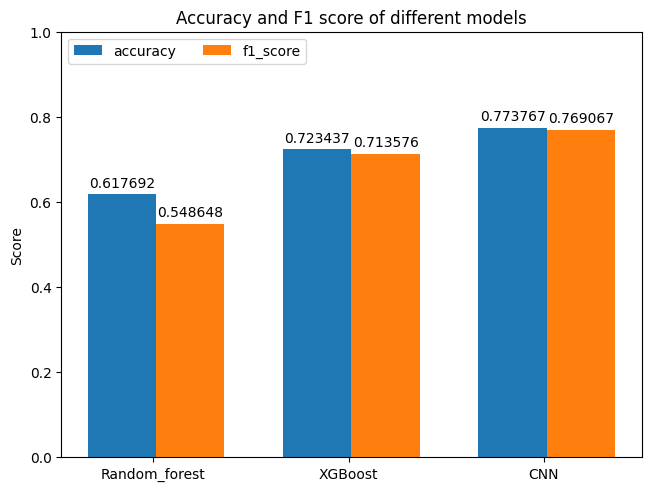

In [89]:
# parameters to plot
models = ['Random_forest', 'XGBoost', 'CNN']
scores = {'accuracy': [accurac_rf, accurac_xgb, accurac_cnn], 'f1_score': [f1_rf, f1_xgb, f1_cnn]}

#plotting bar plot of accuracy score
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots(layout='constrained')
multiplier = 0

#creating the bar plot
for item, values in scores.items():
    offset = width * multiplier
    rects = ax.bar(x+offset, values, width, label=item)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Accuracy and F1 score of different models')
ax.set_xticks(x + width-0.19, models)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

<Axes: >

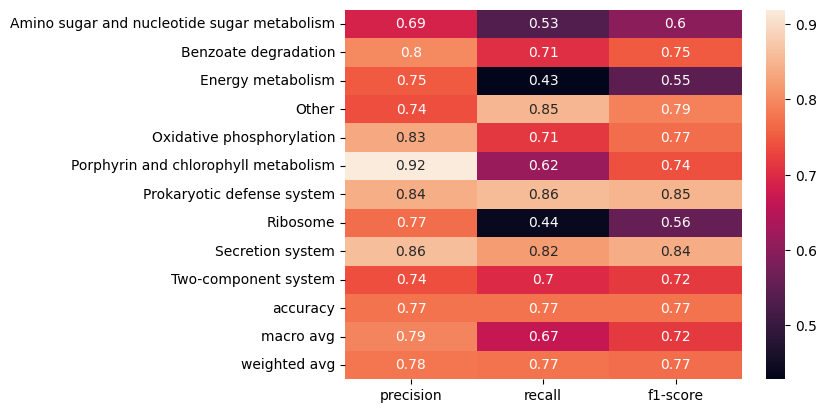

In [64]:
#plotting classification report as heatmap of bes model
sns.heatmap(pd.DataFrame(classification_report(test_y, label_encoder.inverse_transform(predict_y), output_dict=True)).iloc[:-1, :].T, annot=True)

## Predicting functions of hypothetical clusters

Most of the hypothetical clusters were predicted as other, however a considerable amount was predicted in other classes like secrestion system and Prokaryotic defense system with 15895, and 7755 cluster respectively.

In [48]:
# reloading the saved model
with open('outputs/model_cnn_cl_acc.pkl', 'rb') as f:
    model = pickle.load(f)

# predicting hypothetical clusters
hypo_prediction = model.predict(predict_embeddings)
predict_class = label_encoder.inverse_transform(hypo_prediction)

<class 'matplotlib.container.BarContainer'>


[]

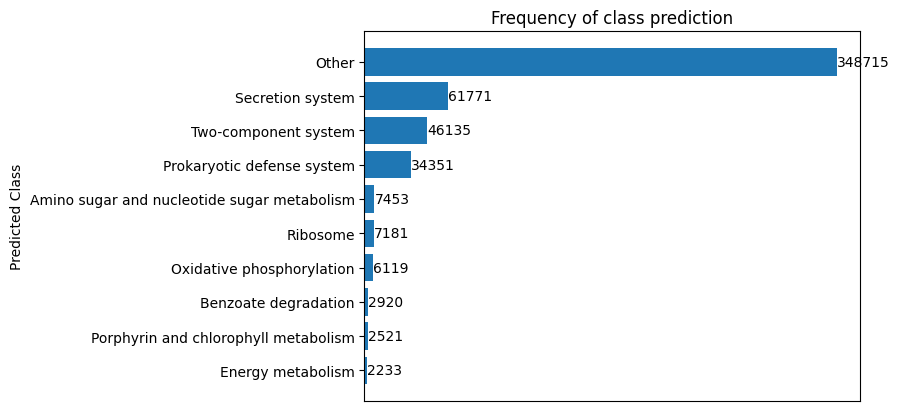

In [78]:
# plotting of the predicted classes_distribution
values = pd.DataFrame(predict_class, columns=['predicted_class'])['predicted_class'].value_counts(dropna=False, ascending=True).keys().tolist()
counts = pd.DataFrame(predict_class, columns=['predicted_class'])['predicted_class'].value_counts(dropna=False, ascending=True).tolist()


#creating the bar plot
fig, ax = plt.subplots()
bars = ax.barh(values, counts)
for container in ax.containers:
    ax.bar_label(container)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Predicted Class')
ax.set_title('Frequency of class prediction')
ax.set_xticks([])



### Testing on genes whise function is newly found.

1- Prokaryotic defense systems: 413 protiens; 90% correctly predicted.


2- Secretion systems: 3201 proteins 100% correctly predicted.


In [130]:
# loading new defense portiens and their mappings
defense= pd.read_csv('./new_systems/domains/defense/hhpred_defense.csv')

# getting the predicted classe of genes
hypo_clusters_defense = defense['Gene'].to_list()
classes_defense = []
for cluster in hypo_clusters_defense:
    index = predict_word_index[cluster]
    classes_defense.append(predict_class[index])
from collections import Counter

# getting the percentage of resulting predictions
counter= Counter(classes_defense)

print(counter)

total_count = sum(counter.values())

# calculating percentages
percentages = {key: (count / total_count) * 100 for key, count in counter.items()}

print(percentages)

Counter({'Prokaryotic defense system': 370, 'Other': 43})
{'Prokaryotic defense system': 89.58837772397095, 'Other': 10.411622276029057}


In [131]:
# getting the data of secreion systems and their mapped clusters
secretion_1= pd.read_csv('./new_systems/domains/clostridia_membrane_machineries/hhpred_clostridia_secretion.csv')
secretion_2= pd.read_csv('./new_systems/domains/veillonella_membrane_machineries/hhpred_veillonella_secretion.csv')

#getting their hypothetical class assignment
hypo_clusters= []
hypo_clusters+= secretion_1['Gene'].to_list()
hypo_clusters+= secretion_2['Gene'].to_list()
secrestion_classes = []
for cluster in hypo_clusters:
    index = predict_word_index[cluster]
    secrestion_classes.append(predict_class[index])

#finding the percentage of preidcted classes
counter= Counter(secrestion_classes)
print(counter)
# Calculate total number of elements
total_count = sum(counter.values())

# calculating percentages
percentages = {key: (count / total_count) * 100 for key, count in counter.items()}

print(percentages)

Counter({'Secretion system': 3201})
{'Secretion system': 100.0}


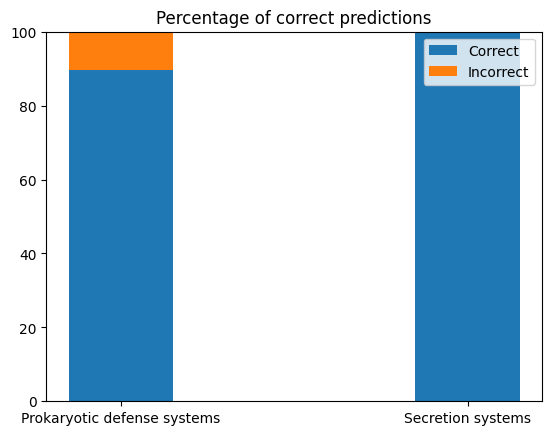

In [136]:
# setting the data
species = (
    'Prokaryotic defense systems', 'Secretion systems'
)
weight_counts = {
    "Correct": np.array([89.58837772397095, 100]),
    "Incorrect": np.array([10.411622276029057, 0]),
}
width = 0.3 #setting the width of the bars

fig, ax = plt.subplots()
bottom = np.zeros(2)

# Plotting the bars
for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Percentage of correct predictions")
ax.legend(loc="upper right")  # adding legend to the plot

plt.show()  # diplaying the plot


## Discussion

* Using NLP techniques, it was possible to build a classification model to predict gene function based on it context.

* Systems whose genes are known to co-occur, abundant, and has its genes clusteres in one to KOs were better predicted.

## Perspectives

* Testing on more data for various classes

* Trying different techniques like Glove for embedding since it studies ‘words’ in the context of the whole corpus.

* Revsiting preprocessing steps, especially filtering and threshold, and clusturing

